In [ ]:
# Step 1: Import Required Libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, when
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Step 2: Initialize Spark Session
spark = SparkSession.builder \
    .appName("HeartDiseasePredictor") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

In [ ]:
# Step 3: Load and Prepare Data
df = spark.read.csv('/content/cardio_train.csv',sep= ';' , header=True, inferSchema=True)

df.show(5)

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
only showing top 5 rows



In [ ]:
#Step 4: Check for null values
from pyspark.sql.functions import col, count

# Count null values in each column
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|  0|     0|     0|     0|    0|    0|          0|   0|    0|   0|     0|     0|
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+



In [ ]:
# Step 5: Data Preprocessing
# Calculate BMI
df = df.withColumn('bmi', col('weight') / ((col('height')/100) ** 2))

# Convert categorical variables
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx")
    for col in ['gender', 'cholesterol', 'gluc']
]

# Create blood pressure features
df = df.withColumn('bp_diff', col('ap_hi') - col('ap_lo'))
df = df.withColumn('has_high_bp',
    when((col('ap_hi') >= 140) | (col('ap_lo') >= 90), 1).otherwise(0))

# Filter implausible values
df = df.filter(
    (col('ap_hi') > 0) &
    (col('ap_lo') > 0) &
    (col('ap_hi') >= col('ap_lo')) &
    (col('height') >= 120) &
    (col('height') <= 220) &
    (col('weight') >= 30) &
    (col('weight') <= 200)
)

In [ ]:
#Display the new dataset
df.show(5)

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+-------+-----------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|               bmi|bp_diff|has_high_bp|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+-------+-----------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|  21.9671201814059|     30|          0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|34.927679158448385|     50|          1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|23.507805325987146|     60|          0|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1| 28.71047932495361|     50|          1|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|23.011176857330703|     40|     

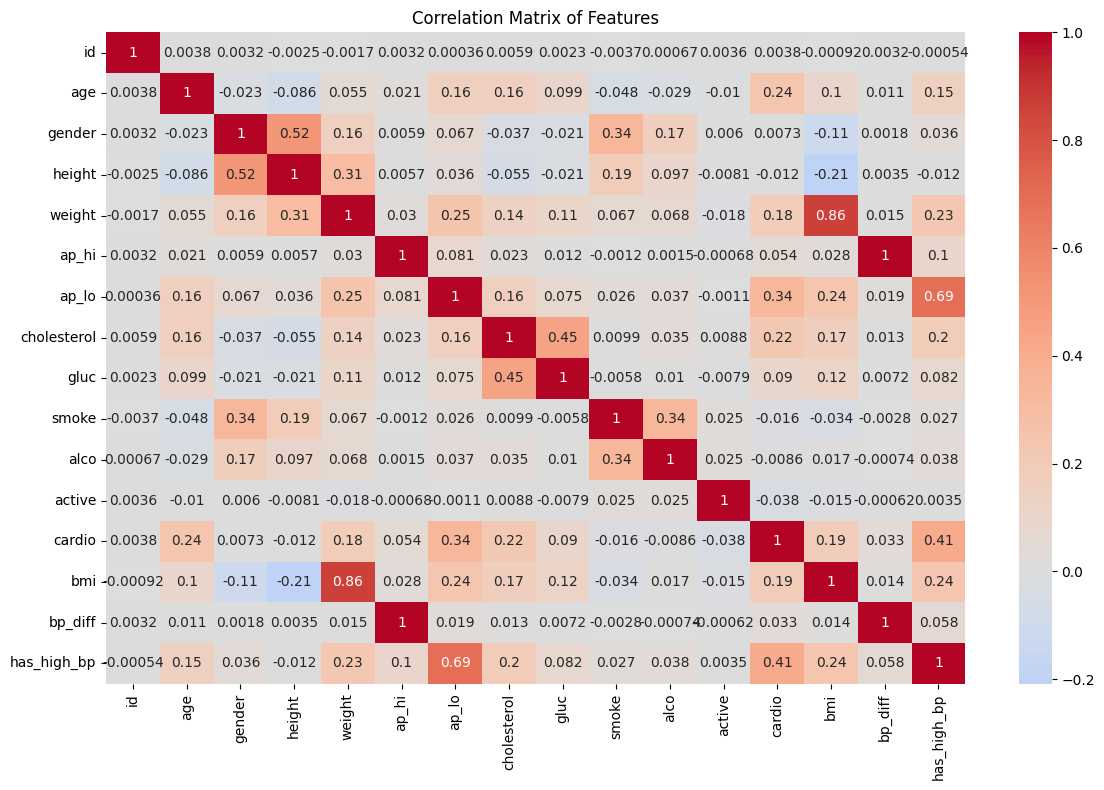

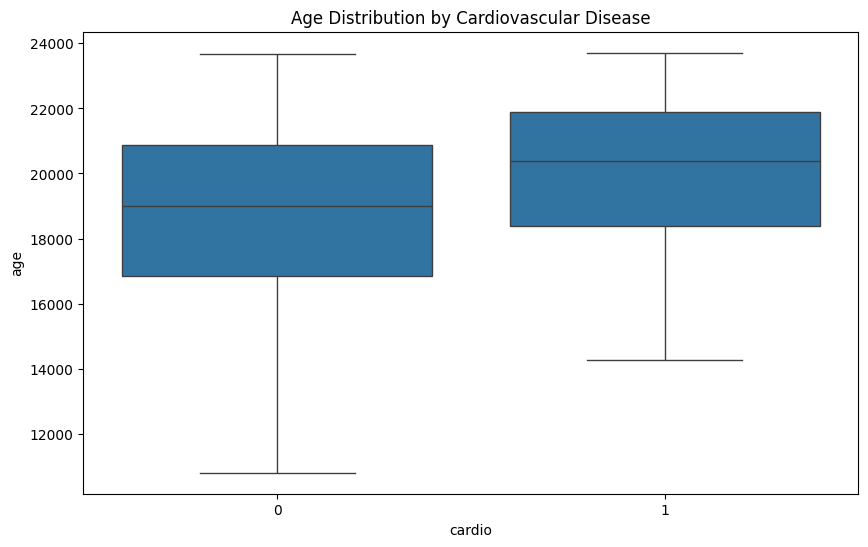

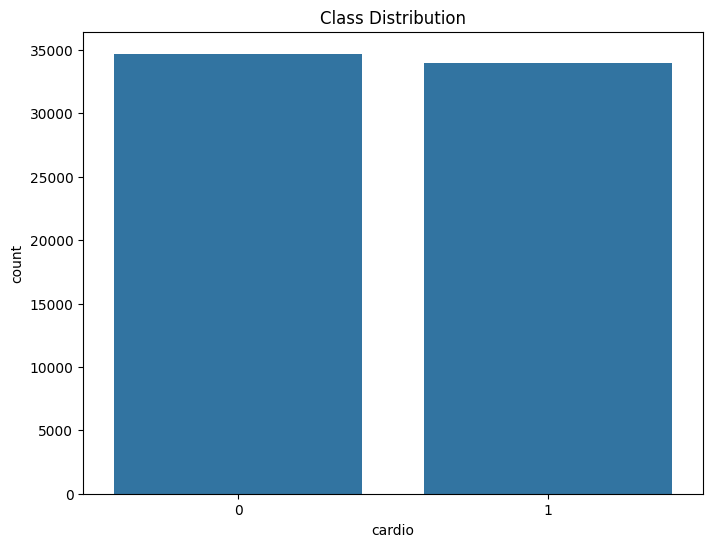

In [ ]:
# Step 6: Exploratory Data Analysis
# Convert to Pandas for visualization
pdf = df.toPandas()

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(pdf.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

# Age distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='cardio', y='age', data=pdf)
plt.title('Age Distribution by Cardiovascular Disease')
plt.show()

# Class distribution
class_counts = df.groupBy('cardio').count().toPandas()
plt.figure(figsize=(8, 6))
sns.barplot(x='cardio', y='count', data=class_counts)
plt.title('Class Distribution')
plt.show()

In [ ]:
# Step 7: Feature Engineering
# Define feature columns
feature_cols = [
    'age', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'bp_diff', 'has_high_bp', 'gender_idx', 'cholesterol_idx', 'gluc_idx', 'smoke', 'alco', 'active'
]
# Create assembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Create scaler
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')

# Create pipeline
pipeline = Pipeline(stages=indexers + [assembler, scaler])

In [ ]:
# Step 8: Split Data
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Step 9: Prepare Data for Models
# Convert PySpark DataFrame to format suitable for ML models
from pyspark.ml.functions import vector_to_array

# Fit the pipeline to the training data
pipeline_model = pipeline.fit(train_df)

# Transform both train and test datasets
train_data = pipeline_model.transform(train_df)
test_data = pipeline_model.transform(test_df)

# Convert features to array format
train_data = train_data.withColumn('features_array', vector_to_array('scaled_features'))
test_data = test_data.withColumn('features_array', vector_to_array('scaled_features'))

# Convert to numpy arrays for XGBoost and KNN
X_train = np.array(train_data.select('features_array').collect())
X_train = np.vstack(X_train)
y_train = np.array(train_data.select('cardio').collect()).ravel()

X_test = np.array(test_data.select('features_array').collect())
X_test = np.vstack(X_test)
y_test = np.array(test_data.select('cardio').collect()).ravel()

# Train XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic',
    tree_method='hist'
)
xgb_model.fit(X_train, y_train)

# Train KNN
print("Training KNN...")
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train, y_train)

# Train ANN
print("Training ANN...")
layers = [len(feature_cols), 20, 10, 2]
ann = MultilayerPerceptronClassifier(
    layers=layers,
    maxIter=100,
    blockSize=128,
    seed=42,
    featuresCol='scaled_features',
    labelCol='cardio'
)
ann_model = ann.fit(train_data)

Training XGBoost...
Training KNN...
Training ANN...


In [ ]:
# Model Evaluation
print("Evaluating models...")
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
import numpy as np

def create_spark_predictions_df(predictions, probabilities, true_labels, spark):
    """
    Create a Spark DataFrame with the required columns for evaluation
    """
    # Convert probabilities to rawPrediction format (required by evaluator)
    # rawPrediction should contain [1-p, p] for binary classification
    raw_predictions = [[1.0 - p, p] for p in probabilities]

    return spark.createDataFrame(
        [(float(pred), Vectors.dense(raw_pred), float(prob), float(true))
         for pred, raw_pred, prob, true in zip(predictions, raw_predictions, probabilities, true_labels)],
        ['prediction', 'rawPrediction', 'probability', 'cardio']
    )

# Create evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol='cardio',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderROC'
)

# XGBoost predictions and evaluation
xgb_predictions = xgb_model.predict(X_test)
xgb_probabilities = xgb_model.predict_proba(X_test)[:, 1]
xgb_pred_df = create_spark_predictions_df(xgb_predictions, xgb_probabilities, y_test, spark)
xgb_auc = evaluator.evaluate(xgb_pred_df)

# KNN predictions and evaluation
knn_predictions = knn_model.predict(X_test)
knn_probabilities = knn_model.predict_proba(X_test)[:, 1]
knn_pred_df = create_spark_predictions_df(knn_predictions, knn_probabilities, y_test, spark)
knn_auc = evaluator.evaluate(knn_pred_df)

# ANN predictions (assuming it's already in the correct format as it's a Spark ML model)
ann_predictions = ann_model.transform(test_data)
ann_auc = evaluator.evaluate(ann_predictions)

# Print results
print("\nModel Performance:")
print(f"XGBoost AUC-ROC: {xgb_auc:.3f}")
print(f"KNN AUC-ROC: {knn_auc:.3f}")
print(f"ANN AUC-ROC: {ann_auc:.3f}")

# Calculate additional metrics
def calculate_additional_metrics(predictions, true_labels):
    """
    Calculate accuracy, precision, recall, and F1 score
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Calculate additional metrics for each model
xgb_metrics = calculate_additional_metrics(xgb_predictions, y_test)
knn_metrics = calculate_additional_metrics(knn_predictions, y_test)
ann_metrics = calculate_additional_metrics(
    ann_predictions.select('prediction').toPandas()['prediction'],
    ann_predictions.select('cardio').toPandas()['cardio']
)

# Print additional metrics
print("\nDetailed Metrics:")
for model_name, metrics in [
    ('XGBoost', xgb_metrics),
    ('KNN', knn_metrics),
    ('ANN', ann_metrics)
]:
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name.capitalize()}: {value:.3f}")

Evaluating models...

Model Performance:
XGBoost AUC-ROC: 0.802
KNN AUC-ROC: 0.728
ANN AUC-ROC: 0.787

Detailed Metrics:

XGBoost:
Accuracy: 0.734
Precision: 0.754
Recall: 0.683
F1: 0.717

KNN:
Accuracy: 0.687
Precision: 0.686
Recall: 0.676
F1: 0.681

ANN:
Accuracy: 0.727
Precision: 0.746
Recall: 0.676
F1: 0.709


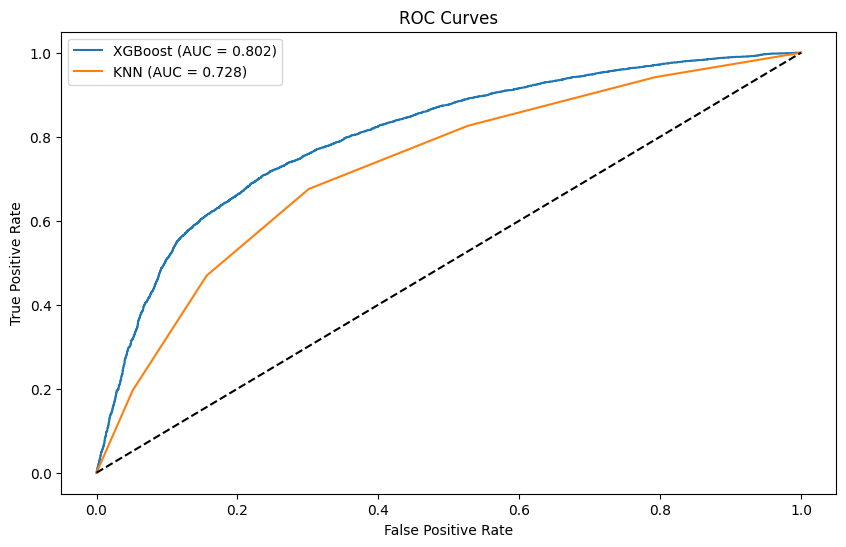

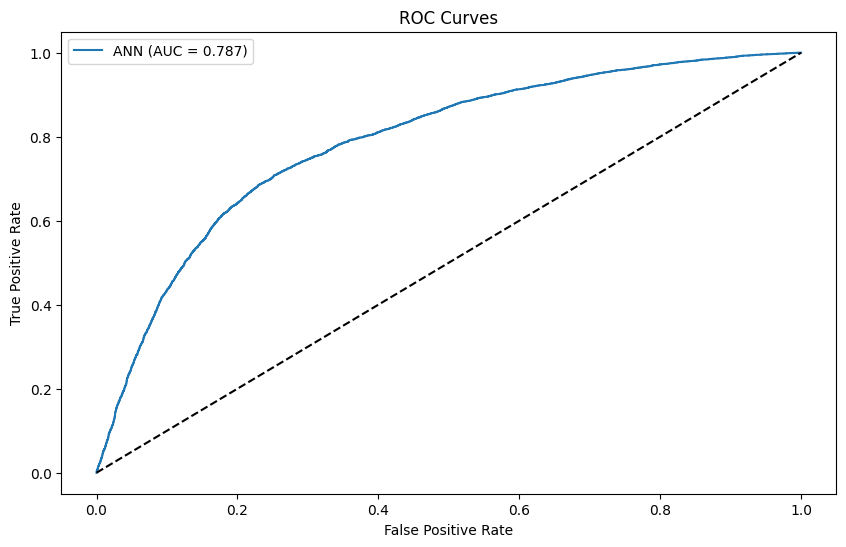

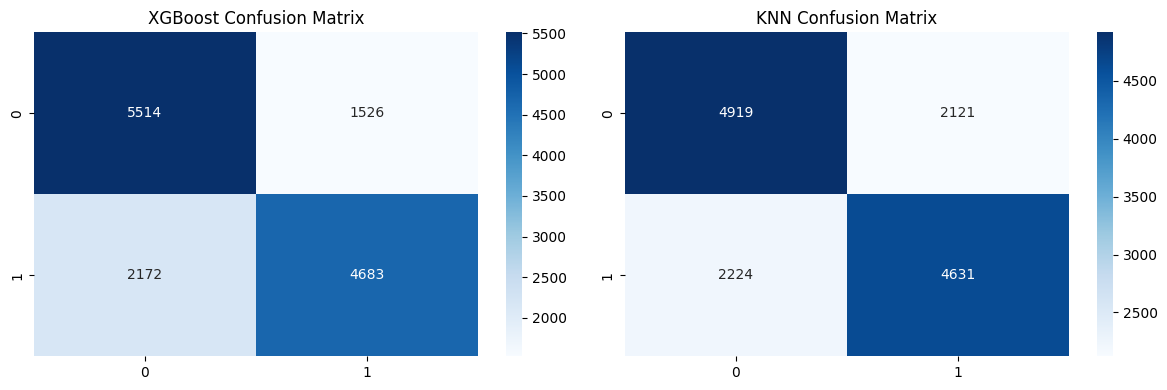

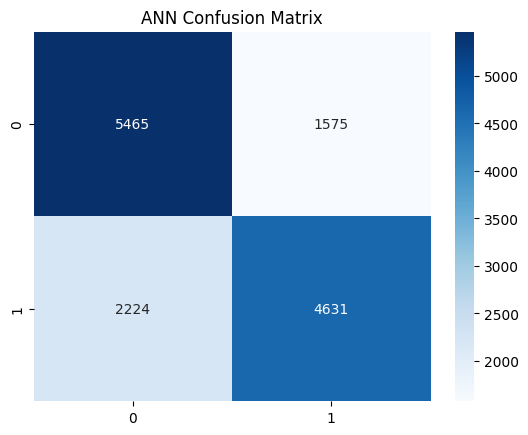

<Figure size 1000x600 with 0 Axes>

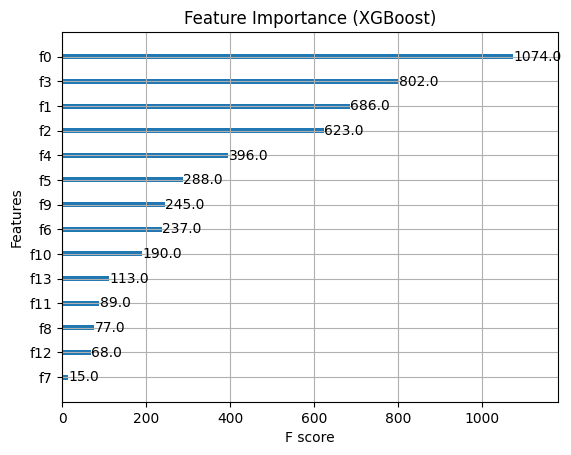

In [ ]:
# Visualize Results
# ROC Curves
plt.figure(figsize=(10, 6))
# XGBoost
fpr, tpr, _ = roc_curve(y_test, xgb_probabilities)
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {xgb_auc:.3f})')
# KNN
fpr, tpr, _ = roc_curve(y_test, knn_probabilities)
plt.plot(fpr, tpr, label=f'KNN (AUC = {knn_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()
#ANN

plt.figure(figsize=(10, 6))
fpr, tpr, _ = roc_curve(y_test, ann_predictions.select('probability').toPandas()['probability'].apply(lambda x: x[1]))
plt.plot(fpr, tpr, label=f'ANN (AUC = {ann_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# XGBoost
cm_xgb = confusion_matrix(y_test, xgb_predictions)
sns.heatmap(cm_xgb, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('XGBoost Confusion Matrix')
# KNN
cm_knn = confusion_matrix(y_test, knn_predictions)
sns.heatmap(cm_knn, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('KNN Confusion Matrix')
plt.tight_layout()
plt.show()
#ANN
cm_ann = confusion_matrix(y_test, ann_predictions.select('prediction').toPandas()['prediction'])
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues')
plt.title('ANN Confusion Matrix')
plt.show()

# Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model)
plt.title('Feature Importance (XGBoost)')
plt.show()

In [ ]:
# Step 13: Print Results
print("\nModel Performance Metrics:")
print(f"XGBoost AUC-ROC: {xgb_auc:.3f}")
print(f"KNN AUC-ROC: {knn_auc:.3f}")
print(f"ANN AUC-ROC: {ann_auc:.3f}")


#stop the spark session
spark.stop()


Model Performance Metrics:
XGBoost AUC-ROC: 0.802
KNN AUC-ROC: 0.728
ANN AUC-ROC: 0.787


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
import numpy as np

def predict_heart_disease():
    """
    Function to take user input and predict heart disease risk using existing models
    """
    # Initialize Spark Session
    spark = SparkSession.builder \
        .appName("HeartDiseasePredictor") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

    print("\n=== Heart Disease Risk Prediction System ===\n")

    try:
        # Gather user input
        print("Please enter the following information:")
        age_years = float(input("Enter age (in years): "))
        age = int(age_years * 365.25)  # Convert years to days
        height = float(input("Enter height (in cm): "))
        weight = float(input("Enter weight (in kg): "))
        gender = input("Enter gender (1 for female, 2 for male): ")
        ap_hi = int(input("Enter systolic blood pressure: "))
        ap_lo = int(input("Enter diastolic blood pressure: "))
        cholesterol = int(input("Enter cholesterol level (1: normal, 2: above normal, 3: well above normal): "))
        gluc = int(input("Enter glucose level (1: normal, 2: above normal, 3: well above normal): "))
        smoke = int(input("Do you smoke? (0: no, 1: yes): "))
        alco = int(input("Do you consume alcohol? (0: no, 1: yes): "))
        active = int(input("Are you physically active? (0: no, 1: yes): "))

        # Validate input ranges
        if not (120 <= height <= 220):
            raise ValueError("Height should be between 120 and 220 cm")
        if not (30 <= weight <= 200):
            raise ValueError("Weight should be between 30 and 200 kg")
        if not (ap_hi > ap_lo):
            raise ValueError("Systolic pressure should be greater than diastolic pressure")
        if not (0 <= age_years <= 100):
            raise ValueError("Age should be between 0 and 100 years")

        # Create a DataFrame with user input
        data = [(age, height, weight, gender, ap_hi, ap_lo,
                cholesterol, gluc, smoke, alco, active)]

        columns = ['age', 'height', 'weight', 'gender', 'ap_hi', 'ap_lo',
                  'cholesterol', 'gluc', 'smoke', 'alco', 'active']

        user_df = spark.createDataFrame(data, columns)

        # Calculate derived features
        user_df = user_df.withColumn('bmi',
            col('weight') / ((col('height')/100) ** 2))
        user_df = user_df.withColumn('bp_diff',
            col('ap_hi') - col('ap_lo'))
        user_df = user_df.withColumn('has_high_bp',
            when((col('ap_hi') >= 140) | (col('ap_lo') >= 90), 1).otherwise(0))

        # Transform using pipeline
        transformed_data = pipeline_model.transform(user_df)

        # Extract the scaled features
        features = transformed_data.select('scaled_features').collect()[0][0].toArray()

        # Make prediction
        features = features.reshape(1, -1)  # Reshape for single prediction
        prediction = xgb_model.predict(features)[0]
        probability = xgb_model.predict_proba(features)[0][1]

        print("\n=== Prediction Results ===")
        print(f"Risk of Heart Disease: {'High' if prediction == 1 else 'Low'}")
        print(f"Probability of Heart Disease: {probability:.2%}")

        # Calculate BMI for risk factor reporting
        bmi = weight / ((height/100) ** 2)

        # Print risk factors and their severity
        print("\nRisk Factor Analysis:")
        risk_factors = []

        if ap_hi >= 140 or ap_lo >= 90:
            severity = "Severe" if ap_hi >= 160 or ap_lo >= 100 else "Moderate"
            risk_factors.append(f"- Blood Pressure: {severity} (Systolic: {ap_hi}, Diastolic: {ap_lo})")

        if cholesterol > 1:
            severity = "High" if cholesterol == 3 else "Moderate"
            risk_factors.append(f"- Cholesterol: {severity}")

        if gluc > 1:
            severity = "High" if gluc == 3 else "Moderate"
            risk_factors.append(f"- Glucose: {severity}")

        if smoke == 1:
            risk_factors.append("- Smoking: Active smoker")

        if bmi >= 25:
            if bmi >= 30:
                risk_factors.append(f"- BMI: Obese (BMI: {bmi:.1f})")
            else:
                risk_factors.append(f"- BMI: Overweight (BMI: {bmi:.1f})")

        if active == 0:
            risk_factors.append("- Physical Activity: Sedentary lifestyle")

        if risk_factors:
            print("Identified risk factors:")
            for factor in risk_factors:
                print(factor)
        else:
            print("No major risk factors identified.")

        # Print recommendations
        print("\nRecommendations:")
        if prediction == 1:
            print("1. Consult a healthcare professional for a thorough evaluation")
            if ap_hi >= 140 or ap_lo >= 90:
                print("2. Regular blood pressure monitoring")
            if cholesterol > 1:
                print("3. Schedule a lipid profile test")
            if gluc > 1:
                print("4. Monitor blood glucose levels")
            if smoke == 1:
                print("5. Consider smoking cessation programs")
            if bmi >= 25:
                print("6. Consult a nutritionist for weight management")
            if active == 0:
                print("7. Gradually increase physical activity under medical supervision")
        else:
            print("1. Continue maintaining a healthy lifestyle")
            print("2. Regular health check-ups")
            print("3. Stay physically active")
            if any([cholesterol > 1, gluc > 1, bmi >= 25]):
                print("4. Monitor your health metrics periodically")

        # Clean up
        spark.stop()

    except ValueError as e:
        print(f"\nError: Please enter valid values - {str(e)}")
        spark.stop()
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
        print("Please ensure all input values are within normal ranges.")
        spark.stop()

In [ ]:
# Use the function
if __name__ == "__main__":
    predict_heart_disease()


=== Heart Disease Risk Prediction System ===

Please enter the following information:
Enter age (in years): k

Error: Please enter valid values - could not convert string to float: 'k'
